In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from src.nflow_utils import *
import os
from src.utils import *
from nflows import transforms, distributions, flows
import torch
import torch.nn.functional as F
from nflows.distributions import uniform
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import wandb
import pickle


#TODO: load best_models, get log probs, and then do logp - logq
#TODO: remove outliers and check SIC curve
#TODO: smaller nflow for CR region



In [2]:
cd ..

/home/rd804/m-anode


In [3]:
pwd

'/home/rd804/m-anode/notebooks'

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


In [4]:
sig_train = 5
try_ = 0

group_name = 'nflows_gaussian_mixture_1'
job_name = f'SR_{sig_train}'
try_no = f'try_{try_}'

with open('data/data.pkl', 'rb') as f:
     data = pickle.load(f)

with open('data/background.pkl', 'rb') as f:
     background = pickle.load(f)

print(background.shape)

with open('results/true_w.pkl', 'rb') as f:
    true_w = pickle.load(f)



back_mean = 0
sig_mean = 3
sig_simga = 0.5
back_sigma = 3

x_train = data[str(sig_train)]['train']['data']
x_train = shuffle(x_train, random_state=10)

x_train , x_val = train_test_split(x_train, test_size=0.5, random_state=22)




(100000,)


44721
200000
44721
200000
44721
200000


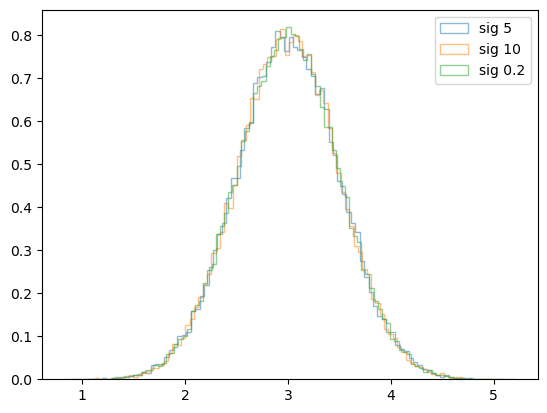

In [5]:
for sig in [5,10,0.2]:
    x_test = data[str(sig)]['val']['data']
    label_test = data[str(sig)]['val']['label']
   # plt.hist(x_test, bins=100, density=True, alpha=0.5, label=f'sig {sig}', histtype='step')
    #plt.hist(x_test[label_test==0], bins=100, density=True, alpha=0.5, label=f'bkg {sig}', histtype='step')
    plt.hist(x_test[label_test==1], bins=100, density=True, alpha=0.5, label=f'sig {sig}', histtype='step')
    print(len(label_test[label_test==1]))
    print(len(label_test[label_test==0]))
    plt.legend()

plt.show()


    #plt.show()


In [6]:

x_test = data['10']['val']['data']
label_test = data['10']['val']['label']

In [31]:
x_test

array([-0.30187762, -0.33098521,  3.13024252, ...,  2.77054224,
        3.42024752,  2.86859011])

In [7]:
test_tensor = torch.from_numpy(x_test.astype('float32').reshape((-1,1))).to(device)
test_loader = torch.utils.data.DataLoader(test_tensor, batch_size=2048, shuffle=False)


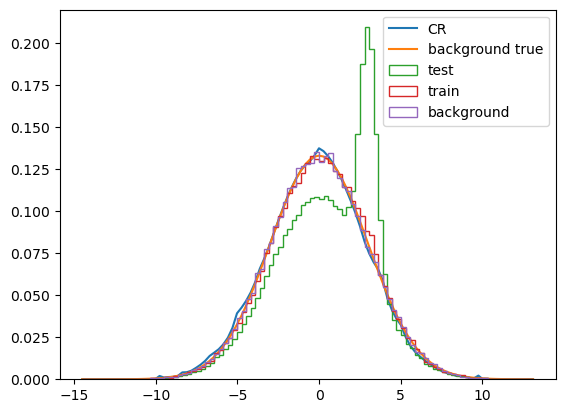

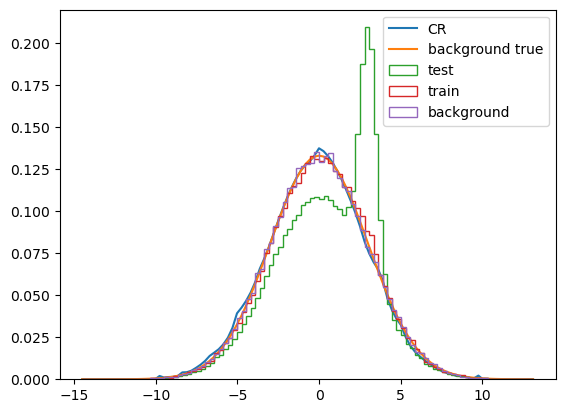

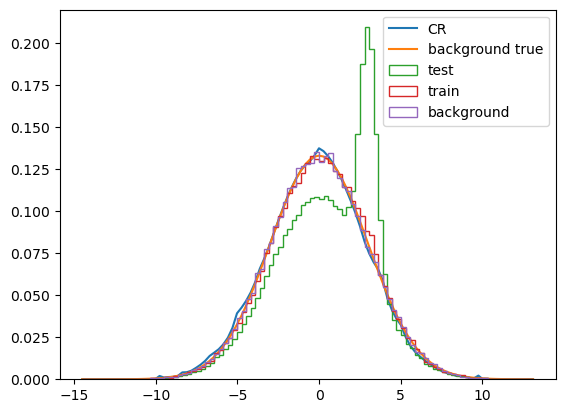

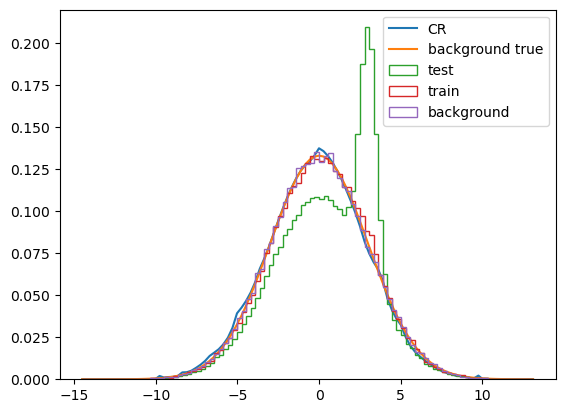

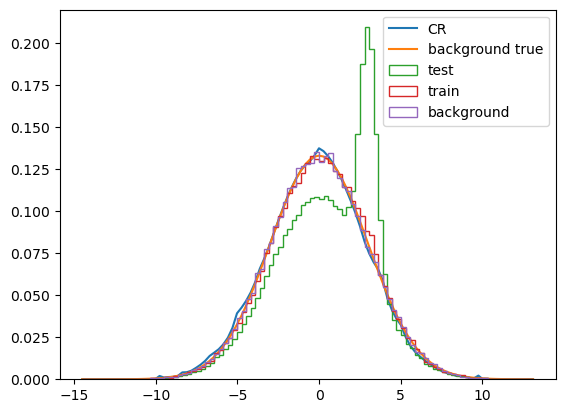

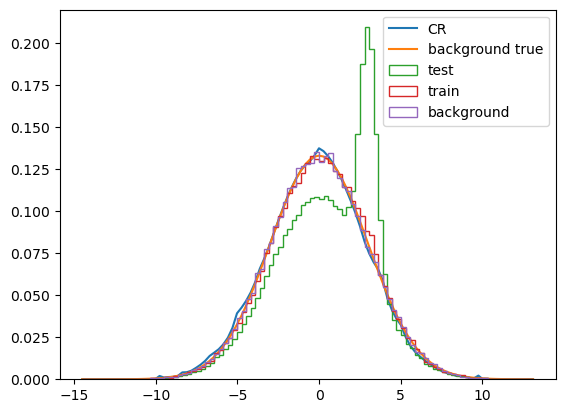

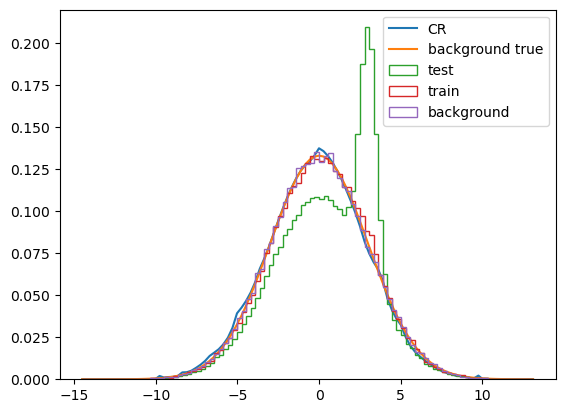

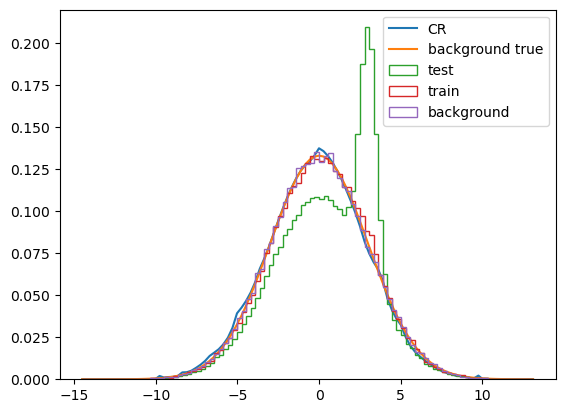

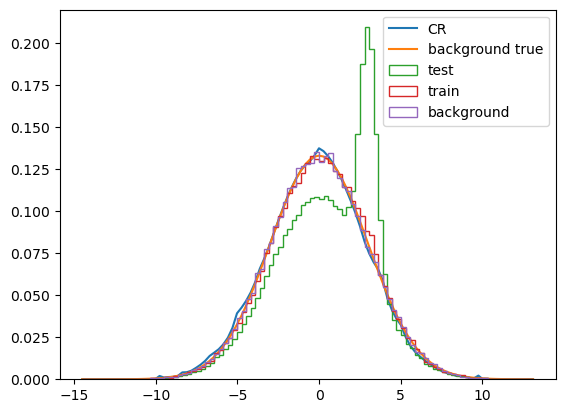

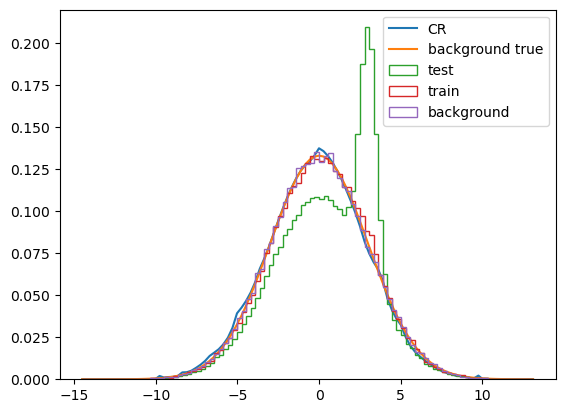

In [61]:
bins = np.linspace(min(x_test), max(x_test), 100)



CR = []
test_log_prob_array_CR = []
score_CR = []
best_loss_model_CR = []

model = define_model(nfeatures=1,nhidden=2,hidden_size=20,embedding=None,dropout=0,nembedding=0,device=device)

for i in range(10):
    # load best model
   # model=define_model(nfeatures=1,nhidden=2,hidden_size=20,embedding=None,dropout=0,nembedding=0,device=device)

    model_file = f'results/{group_name}/CR/{try_no}/model_CR_best.pt'
    val_file = f'results/{group_name}/CR/{try_no}/valloss_list_background.npy'

    index = np.argmin(np.load(val_file))


    model.load_state_dict(torch.load(model_file))
    model.eval()
    model.to(device)


    density_estimator = np.exp(model.log_prob(torch.tensor(bins.reshape(-1,1)).float().to(device)).detach().cpu().numpy())

    test_log_prob = model.log_prob(test_tensor).cpu().detach().numpy()
    test_log_prob_array_CR.append(test_log_prob)

    score_file = f'results/{group_name}/CR/{try_no}/best_val_loss_scores.npy'
    score = np.load(score_file)
    score_CR.append(score)

    model_file = f'results/{group_name}/CR/{try_no}/model_CR_{index}.pt'
    model.load_state_dict(torch.load(model_file))
    model.eval()
    model.to(device)

    best_loss_model = model.log_prob(test_tensor).cpu().detach().numpy()
    best_loss_model_CR.append(np.exp(best_loss_model))




    plt.plot(bins,density_estimator,label='CR')
    plt.plot(bins, p_back(bins,back_mean,back_sigma**2),label='background true')
    plt.hist(x_test,bins=bins,label='test',density=True,histtype='step')
    plt.hist(x_train,bins=bins,label='train',density=True,histtype='step')
    plt.hist(background,bins=bins,label='background',density=True,histtype='step')
    plt.legend()
    plt.show()

    #CR.append(density_estimator)

#CR = np.array(CR)
#CR = np.mean(CR,axis=0)

#plt.plot(bins,CR,label='CR')
#plt.hist(x_test,bins=bins,label='test',density=True,histtype='step')
#plt.hist(x_train,bins=bins,label='train',density=True,histtype='step')
#plt.hist(background,bins=bins,label='background',density=True,histtype='step')
#plt.legend()
#plt.show()


In [158]:
np.sum(np.array(score_CR) - np.exp(test_log_prob_array_CR))

0.0

In [157]:
np.sum(np.array(score_CR) - np.array(best_loss_model_CR))

0.0

/tmp/ipykernel_1033393/467069059.py:46: RuntimeWarning: invalid value encountered in divide
  plt.plot(bins, density_estimator_SR/density_estimator,label='SR/CR')


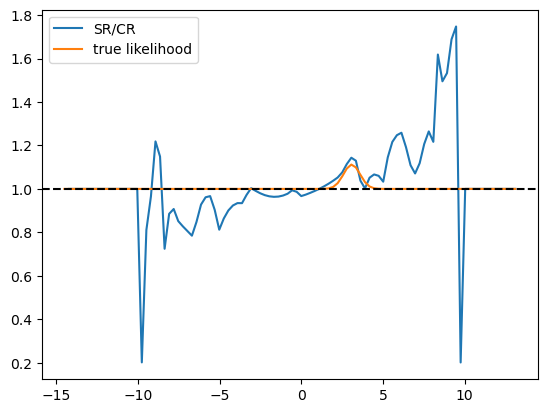

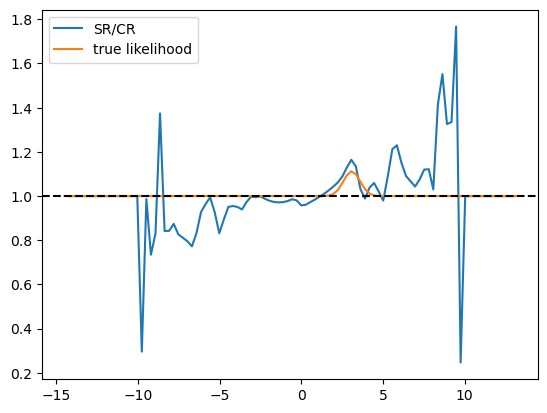

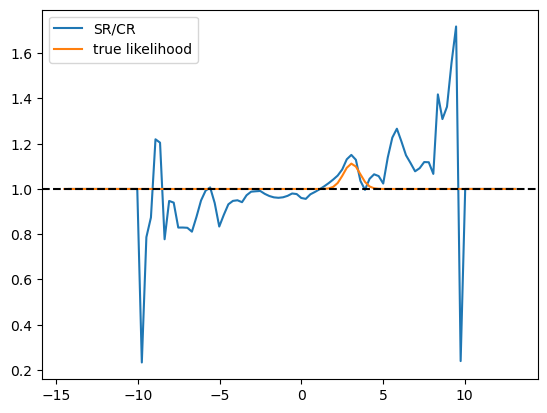

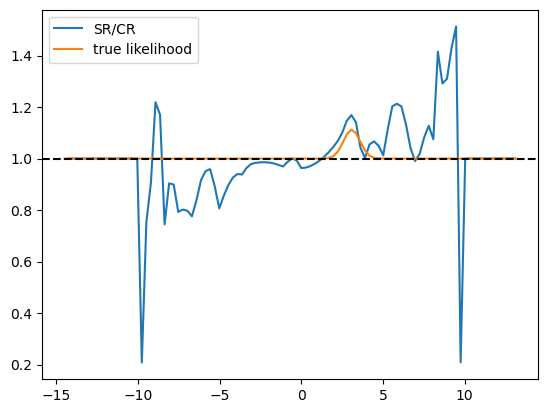

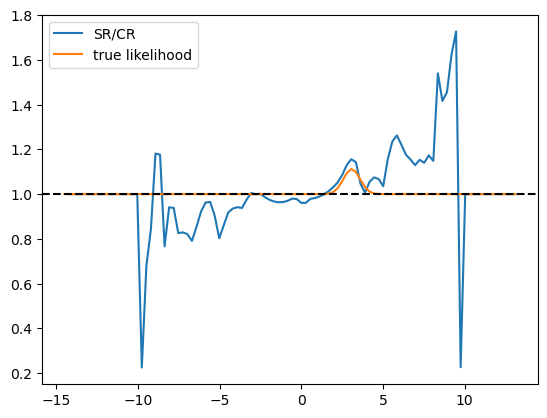

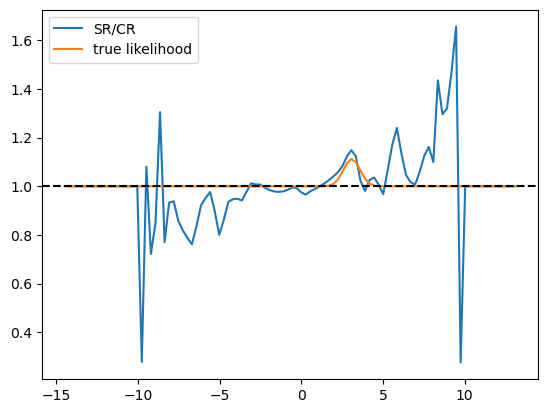

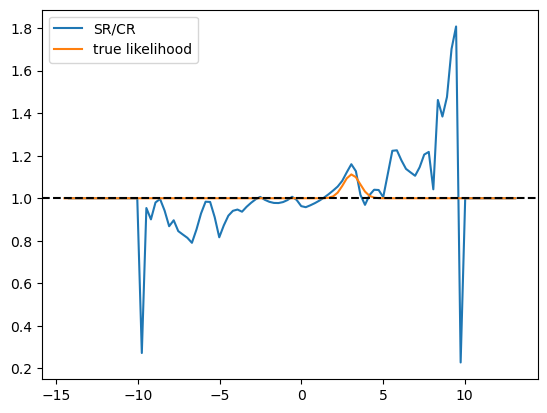

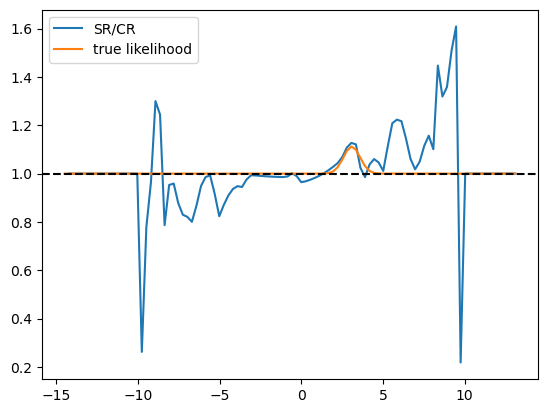

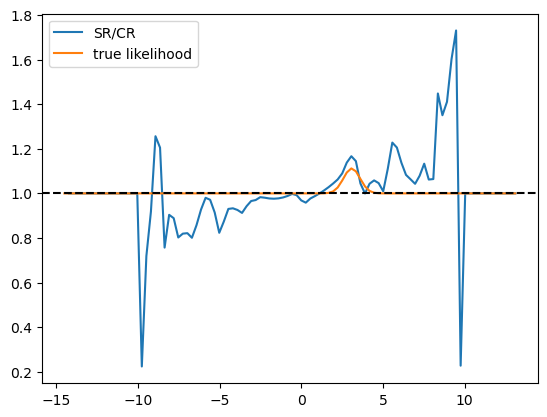

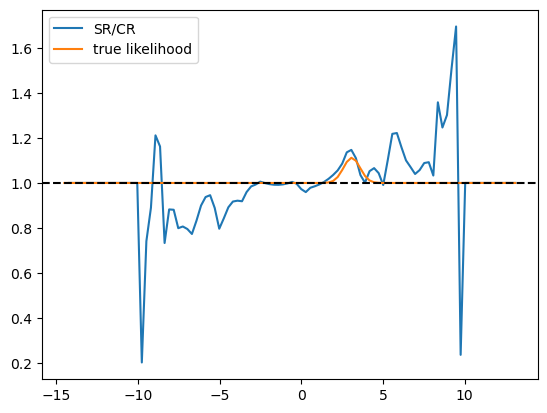

In [64]:
SR = []
sig_train = 5

test_log_prob_array_SR = []
score_SR = []
best_loss_model_SR = []

x_test = data[str(sig_train)]['val']['data']
label_test = data[str(sig_train)]['val']['label']

w1 = true_w[str(sig_train)][0]
w2 = true_w[str(sig_train)][1]

test_tensor = torch.from_numpy(x_test.astype('float32').reshape((-1,1))).to(device)

for i in range(10):
    try_no = f'try_{i}'
  #  model=define_model(nfeatures=1,nhidden=2,hidden_size=20,embedding=None,dropout=0,nembedding=0,device=device)

    model_file = f'results/{group_name}/SR_{sig_train}/{try_no}/model_SR_best.pt'
    val_file = f'results/{group_name}/SR_{sig_train}/{try_no}/valloss_list.npy'
    model.load_state_dict(torch.load(model_file))
    model.eval()
    model.to(device)
    density_estimator_SR = np.exp(model.log_prob(torch.tensor(bins.reshape(-1,1)).float().to(device)).detach().cpu().numpy())

    test_log_prob = model.log_prob(test_tensor).cpu().detach().numpy()
    test_log_prob_array_SR.append(test_log_prob)

    score_file = f'results/{group_name}/SR_{sig_train}/{try_no}/best_val_loss_scores.npy'
    score_SR.append(np.load(score_file))



    index = np.argmin(np.load(val_file))
    model_file = f'results/{group_name}/SR_{sig_train}/{try_no}/model_SR_{index}.pt'
    model.load_state_dict(torch.load(model_file))
    model.eval()
    model.to(device)

    best_loss_model = model.log_prob(test_tensor).cpu().detach().numpy()
    best_loss_model_SR.append(np.exp(best_loss_model))

   # plt.plot(bins,density_estimator,label='CR')
   # plt.plot(bins, density_estimator_SR,label='SR')
    plt.plot(bins, density_estimator_SR/density_estimator,label='SR/CR')
    plt.plot(bins, p_data(bins,[sig_mean,back_mean],[sig_simga**2,back_sigma**2],[w1,w2])/
             (w2 *p_back(bins,back_mean,back_sigma**2)),label='true likelihood')
   # plt.plot(bins,p_data(bins,[sig_mean,back_mean],[sig_simga**2,back_sigma**2]
   # ,[w1,w2]),label='signal true')
   # plt.plot(bins, p_back(bins,back_mean,back_sigma**2),label='background true')
   # plt.plot(bins,CR,label='avg CR')
   # plt.hist(x_test,bins=bins,label='test',density=True,histtype='step')
   # plt.hist(x_train,bins=bins,label='train',density=True,histtype='step')
    plt.axhline(1,linestyle='--',color='black')
    plt.legend()
    plt.show()

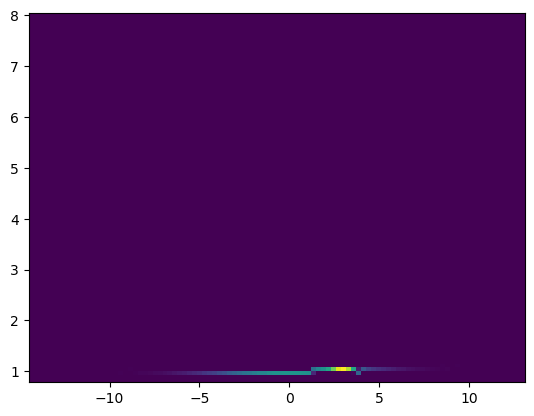

In [39]:
plt.hist2d(x_test, test_log_prob_array_CR[0]/test_log_prob_array_SR[0], bins=100)
plt.show()

In [216]:
np.sum(np.array(score_SR) - np.exp(test_log_prob_array_SR))

1.4901161e-08

In [193]:
print(score_SR[0])
print(np.exp(test_log_prob_array_SR[0]))

[0.13126059 0.13135767 0.08450845 ... 0.09156575 0.07523177 0.08917687]
[0.13126059 0.13135767 0.08450845 ... 0.09156575 0.07523177 0.08917687]


In [32]:
print(sig_train)

w1 = true_w[str(sig_train)][0]
w2 = true_w[str(sig_train)][1]
true_likelihood = p_data(x_test,[sig_mean, back_mean],[sig_simga**2,back_sigma**2],[w1,w2])/p_back(x_test,back_mean,back_sigma**2)

5


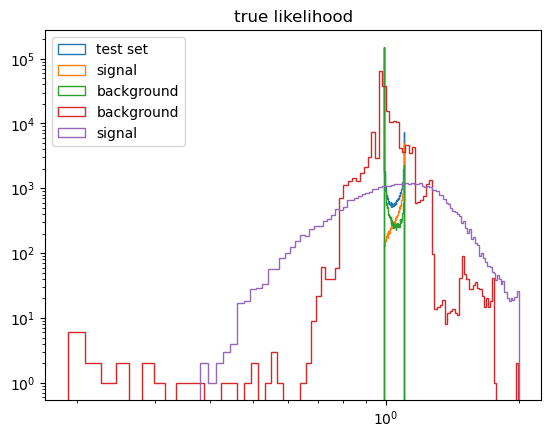

In [236]:
plt.hist(true_likelihood,bins=100, histtype='step', label='test set')
plt.hist(true_likelihood[label_test==1],bins=100, histtype='step', label='signal')
plt.hist(true_likelihood[label_test==0],bins=100, histtype='step', label='background')


plt.hist(likelihood_[label_test_==0],bins=100, histtype='step', label='background')
plt.hist(likelihood_[label_test_==1],bins=100, histtype='step', label='signal')
#plt.hist(np.exp(test_log_prob_array_SR[0]-test_log_prob_array_CR[0])[label_test==0],bins=100, histtype='step', label='SR')
plt.title('true likelihood')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

In [234]:
likelihood_ = np.exp(test_log_prob_array_SR[0]-test_log_prob_array_CR[0])
label_test_ = label_test[likelihood_<2]
likelihood_ = likelihood_[likelihood_<2]


In [220]:
likelihood_[np.argsort(likelihood_)]

array([1.9015606e-01, 1.9973598e-01, 1.9995783e-01, ..., 1.6861295e+18,
       1.9347582e+18, 1.9836112e+18], dtype=float32)

In [226]:
likelihood_.shape

(244721,)

In [225]:
likelihood_[likelihood_<10].shape

(244704,)

In [65]:
likelihood_array = []
p_q_array = []
test_array = []
score_array = []

for i in range(10):
    log_p_q = test_log_prob_array_SR[i] - test_log_prob_array_CR[i]

  #  p = np.exp(test_log_prob_array_SR[i])
  #  q = np.exp(test_log_prob_array_CR[i])



  #  p_ = p
  #  test_array.append(label_test[mean_CR>0])
   # q_ = mean_CR[mean_CR>0]



   # p_q = p/q
    likelihood_array.append(log_p_q)
   # likelihood_array.append(log_p_q)
   # p_q_array.append(p_q)

   # score_p = score_SR[i][mean_CR>0]

   # score_p_q = score_p/q_

   # score_array.append(score_p_q)



In [11]:
mean_CR = np.exp(np.array(test_log_prob_array_CR)).mean(axis=0)
mean_CR 

array([0.13062504, 0.13059708, 0.07436909, ..., 0.08142273, 0.07461596,
       0.07288366], dtype=float32)

In [187]:
x_test.shape

(244721,)

In [25]:
def SIC(label, score):
    fpr, tpr, thresholds = roc_curve(label, score)
    auc = roc_auc_score(label, score)

   # tpr = tpr[fpr>0]
   # fpr = fpr[fpr>0]

    sic = tpr/np.sqrt(fpr)

    return sic, tpr, auc

In [13]:
def find_tpr_threshold(label, score,  tpr_target):
    fpr, tpr, thresholds = roc_curve(label, score)

    index = np.argmin(np.abs(tpr - tpr_target))

    return thresholds[index]


In [67]:
sig_train

5

/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)


0.8786435156302408
thresh 0.088282585
thresh_true 1.0378078455050712


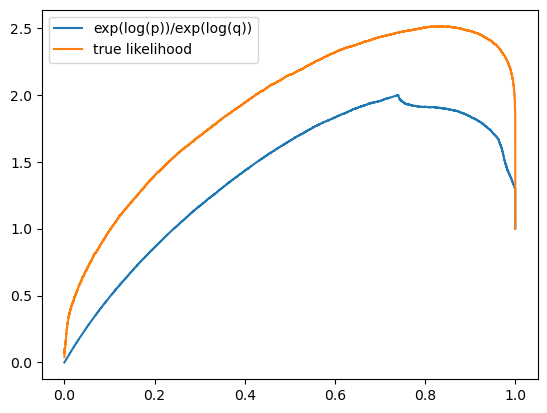

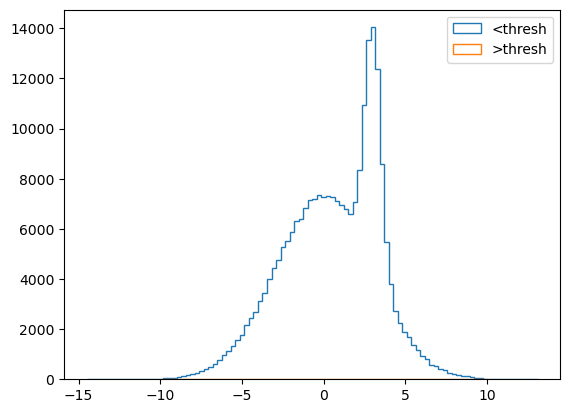

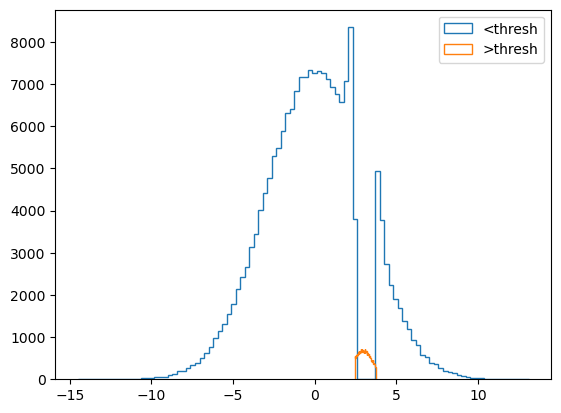

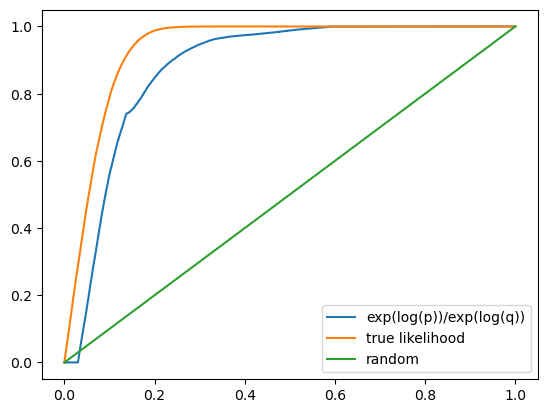

/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)


0.8858470883924778
thresh 0.096565485
thresh_true 1.0378078455050712


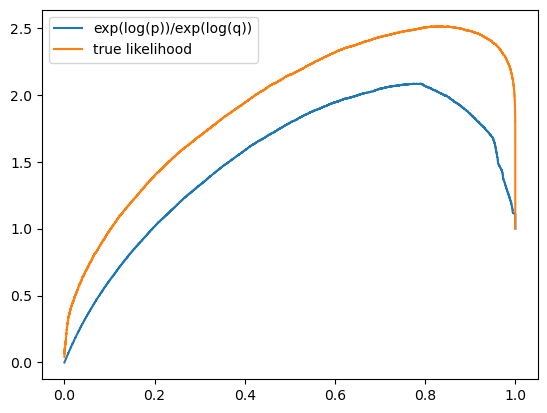

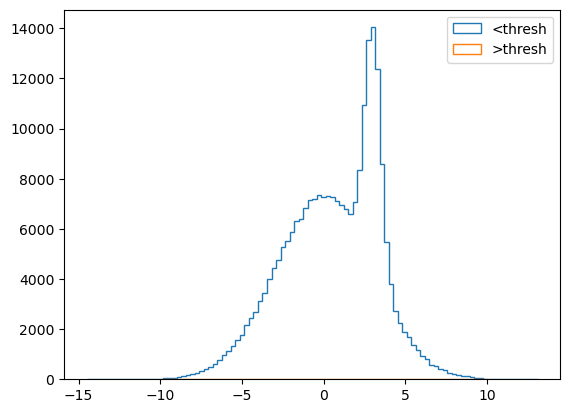

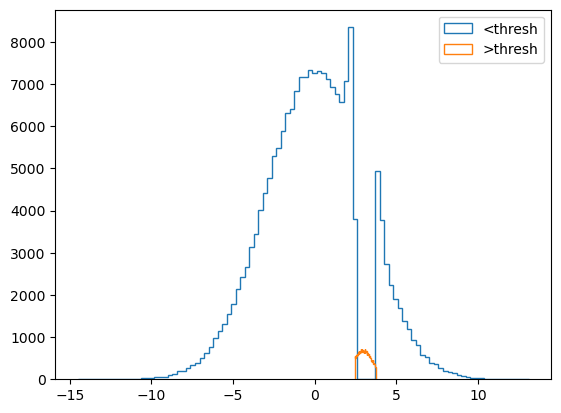

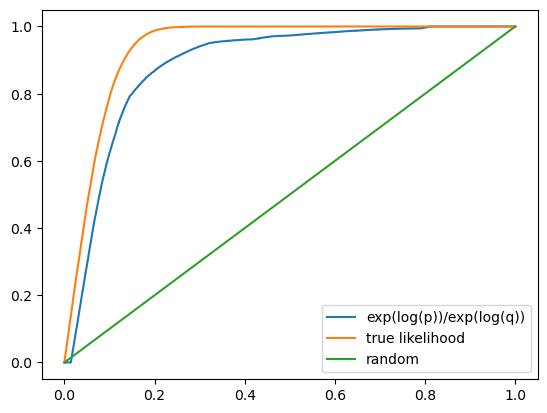

/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)


0.8826403004181481
thresh 0.095562935
thresh_true 1.0378078455050712


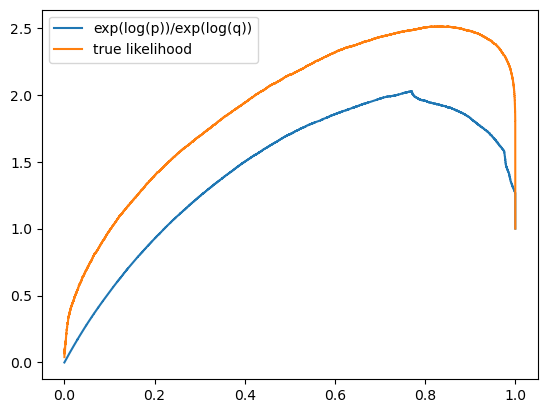

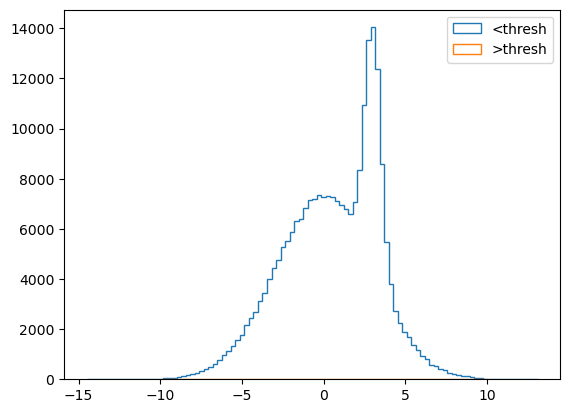

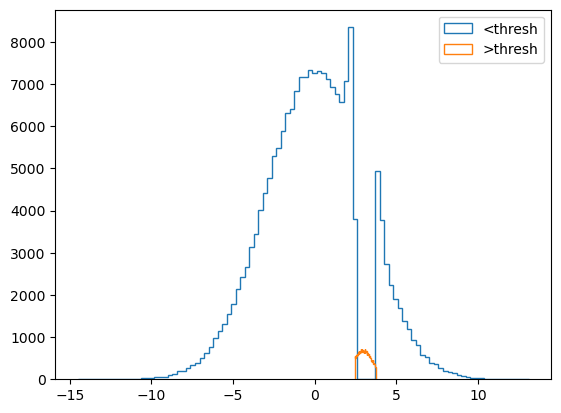

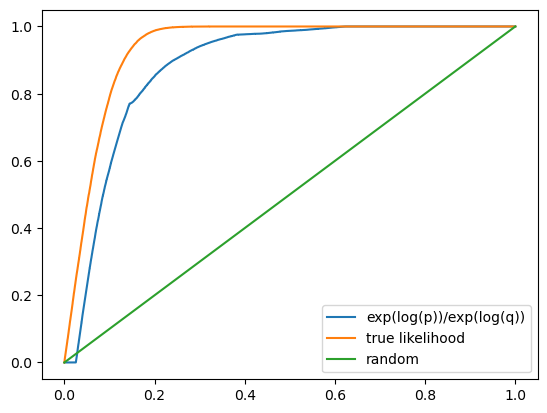

/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)


0.8917021003555377
thresh 0.10799384
thresh_true 1.0378078455050712


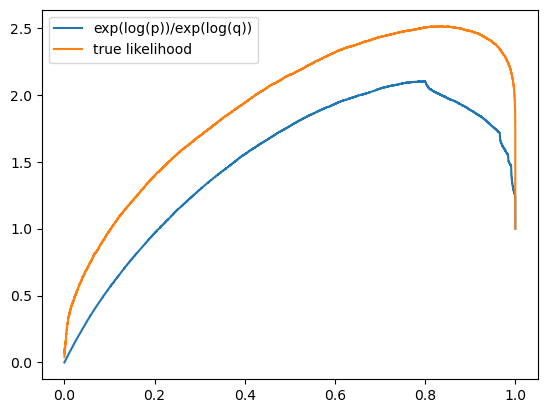

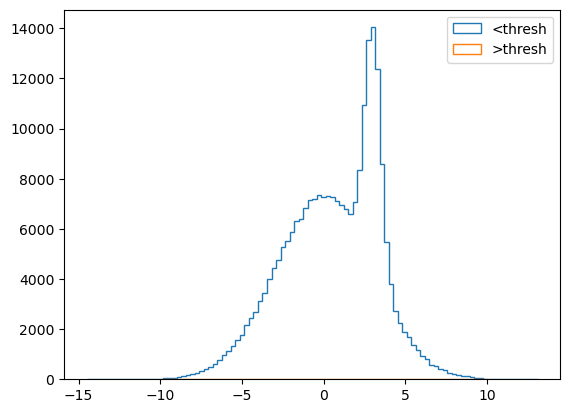

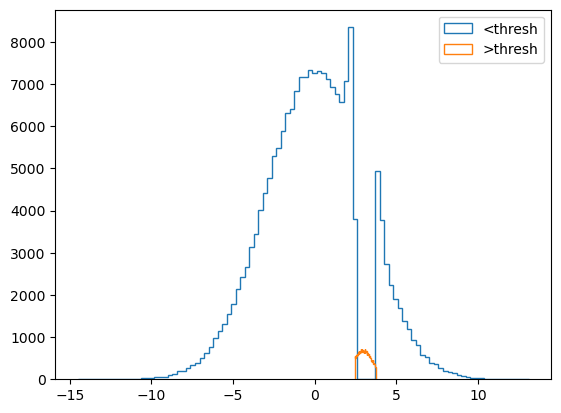

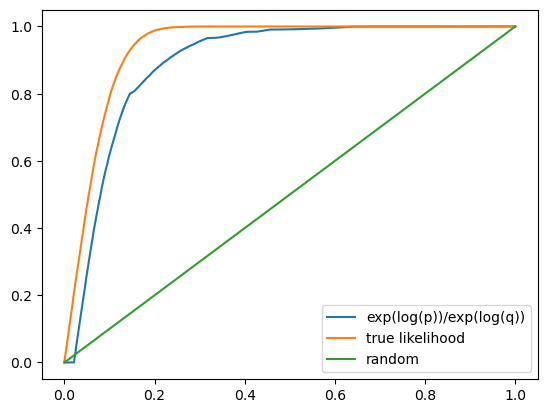

/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)


0.8824531977706224
thresh 0.09889364
thresh_true 1.0378078455050712


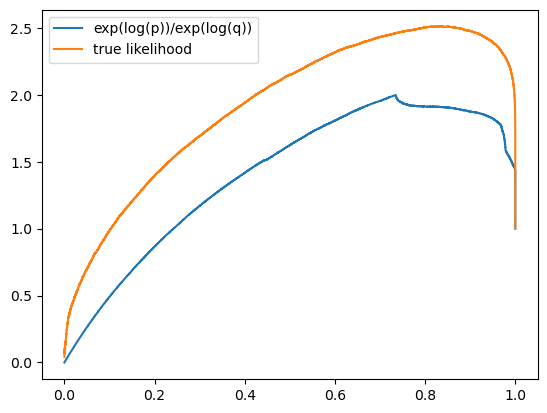

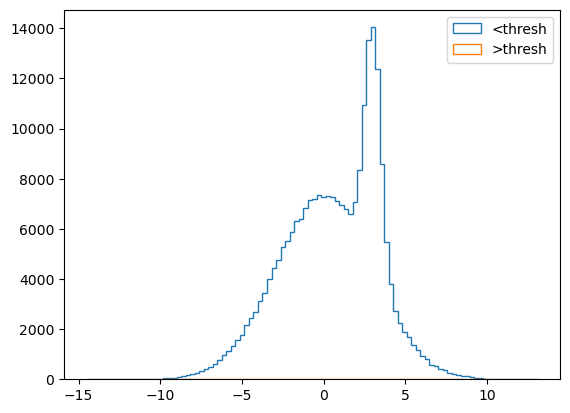

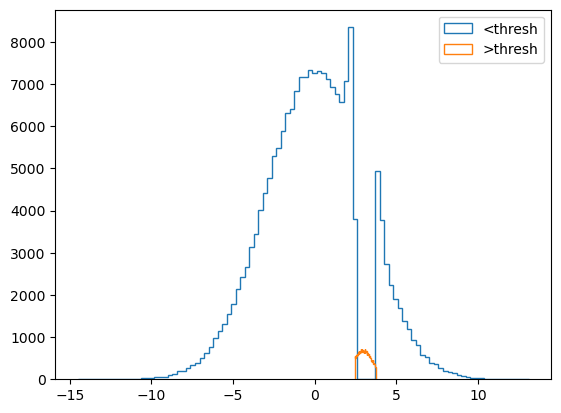

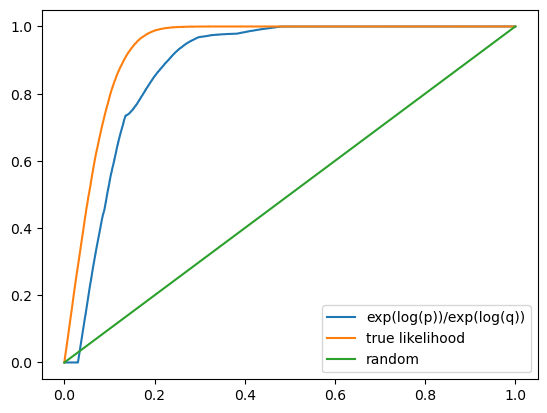

/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)


0.8753871423939537
thresh 0.08974218
thresh_true 1.0378078455050712


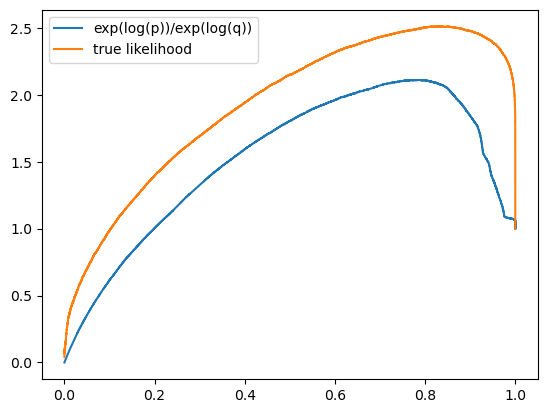

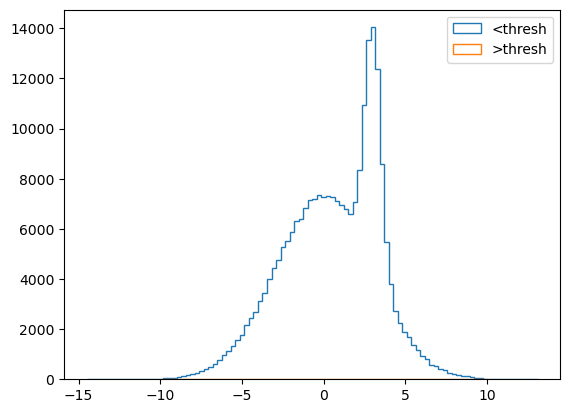

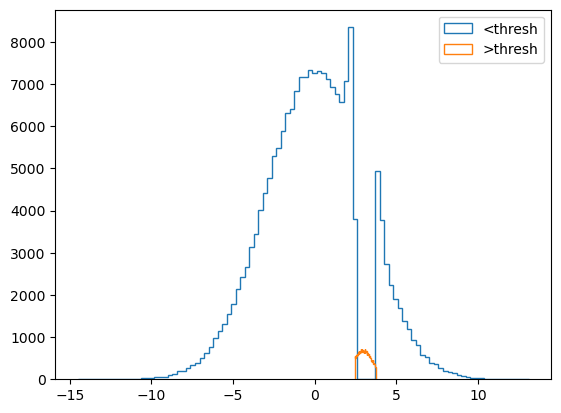

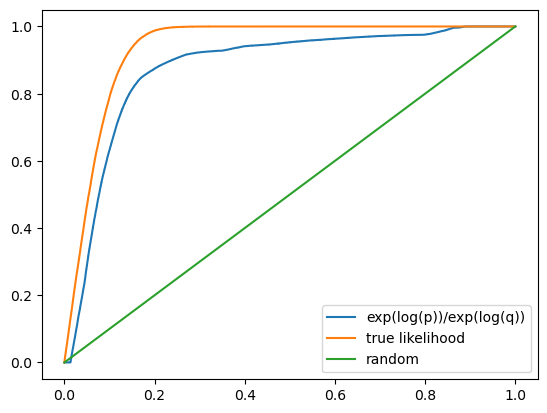

/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)


0.8591865543033474
thresh 0.08985567
thresh_true 1.0378078455050712


/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)


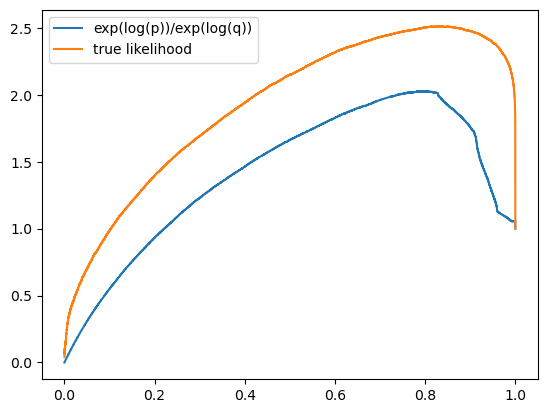

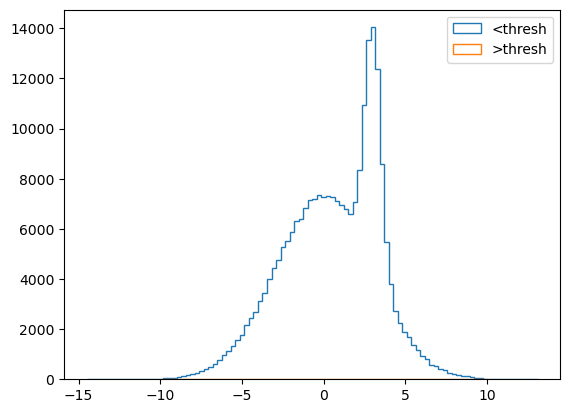

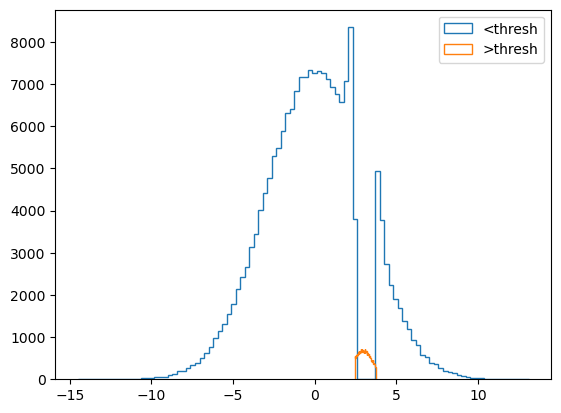

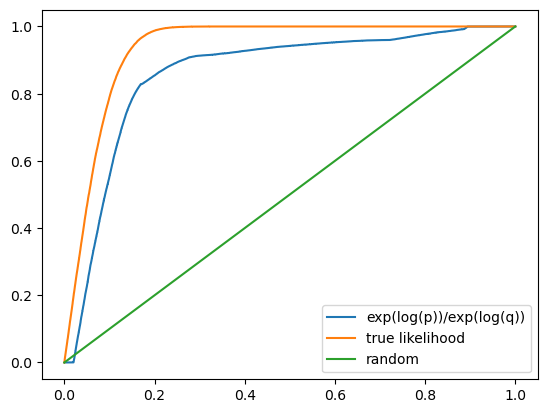

/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)


0.8697869541155162
thresh 0.080340385
thresh_true 1.0378078455050712


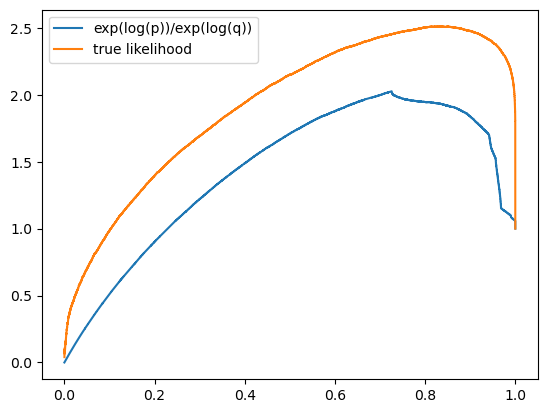

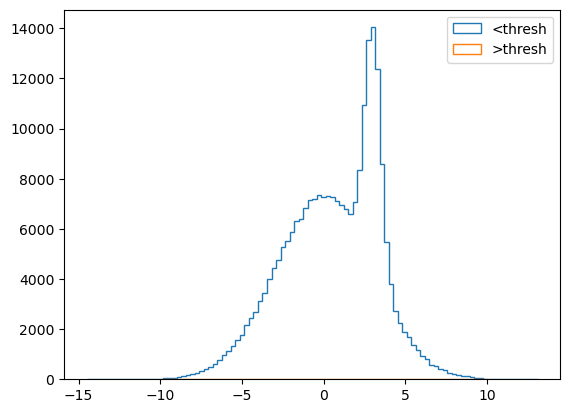

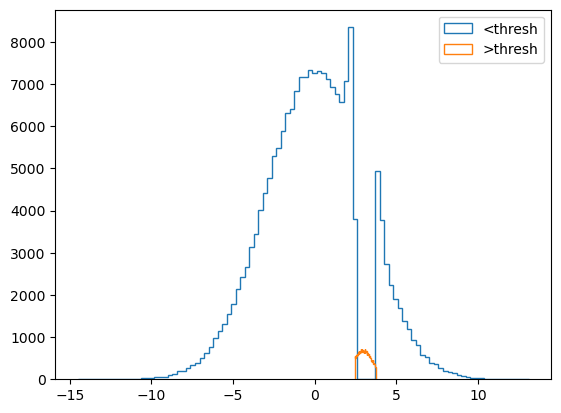

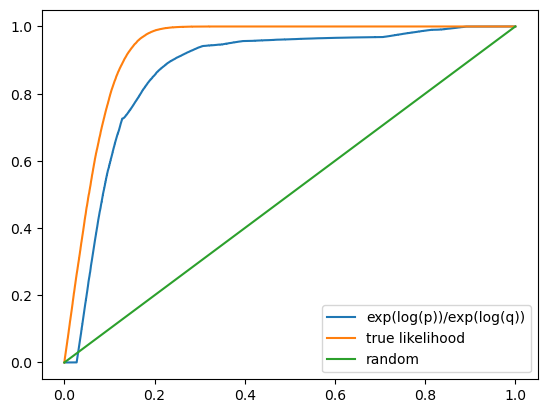

/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)


0.8934369914022494
thresh 0.10127473
thresh_true 1.0378078455050712


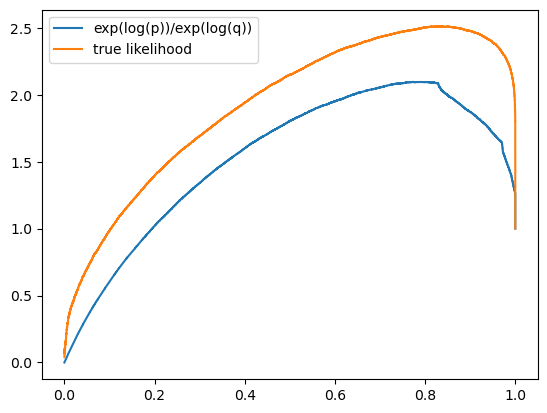

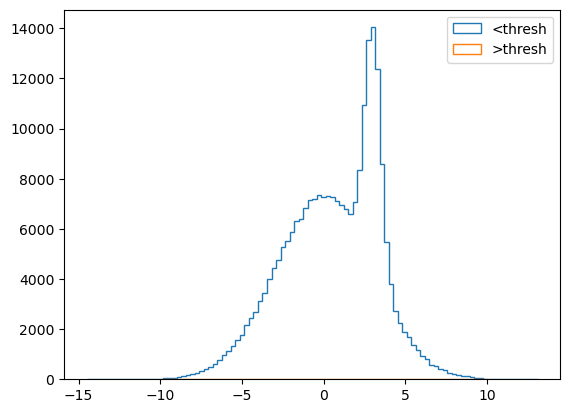

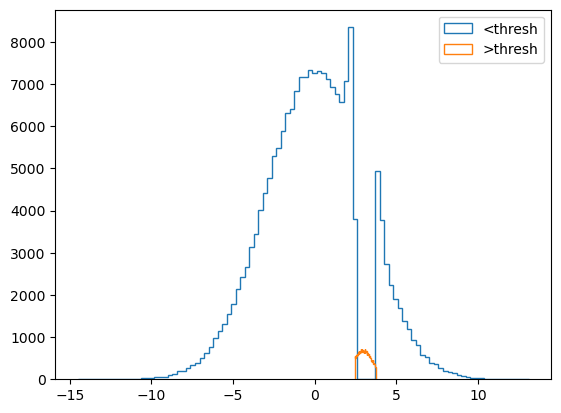

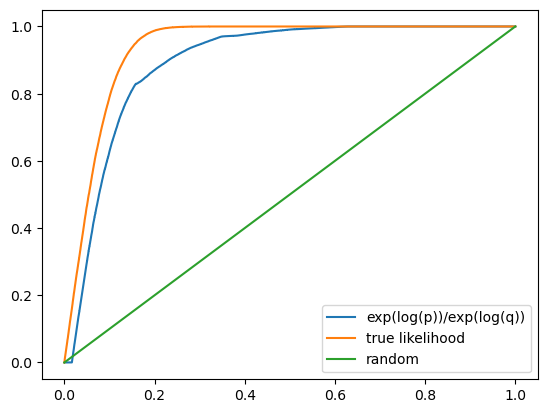

/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_1033393/4238817364.py:8: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)


0.8833081846336174
thresh 0.09208536
thresh_true 1.0378078455050712


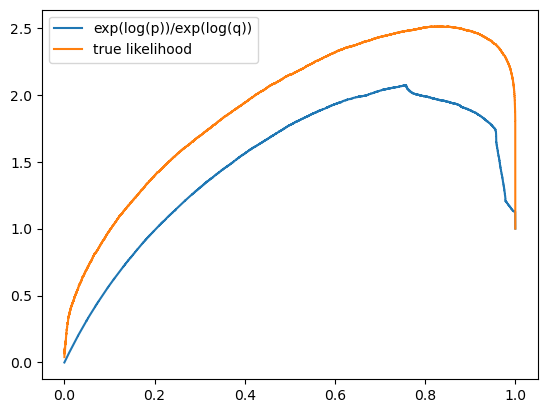

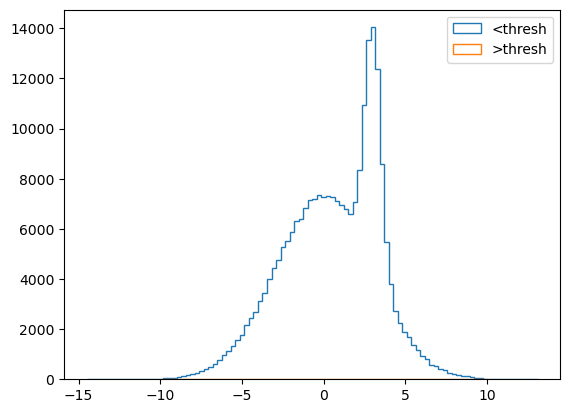

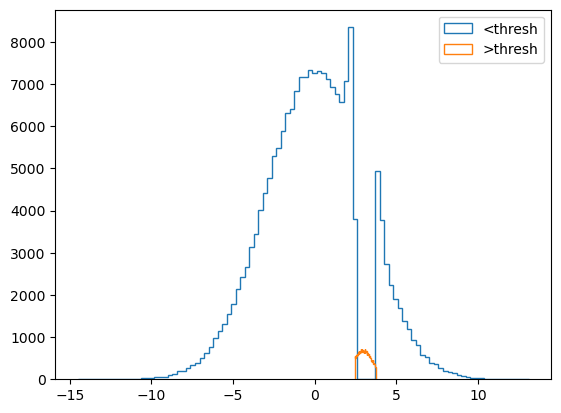

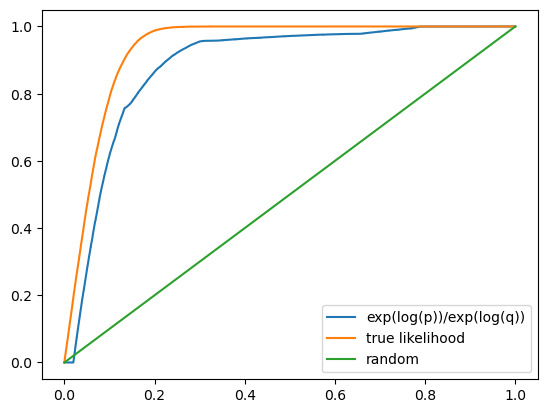

In [66]:
#p_q_array = np.nan_to_num(np.array(p_q_array),nan=0)
for i in range(10):
    

    likelihood_ = likelihood_array[i]

    
    sic_likelihood , tpr_likelihood , auc = SIC(label_test,likelihood_)

    thresh = find_tpr_threshold(label_test,likelihood_,0.6)
    print(auc)

    thresh_true = find_tpr_threshold(label_test,true_likelihood,0.8)

    print('thresh',thresh)
    print('thresh_true',thresh_true)


  #  sic_log_p_q , tpr_log_p_q , auc = SIC(test_array[i],p_q_array[i])
    sic_true , tpr_true , auc = SIC(label_test,true_likelihood)
  #  sic_score , tpr_score , auc = SIC(test_array[i],score_array[i])

    fpr_true, tpr_true, thresholds = roc_curve(label_test, true_likelihood)
    fpr_likelihood, tpr_likelihood, thresholds = roc_curve(label_test, likelihood_)


    plt.plot(tpr_likelihood,sic_likelihood,label='exp(log(p))/exp(log(q))')
  #  plt.plot(tpr_score,sic_score,label='score p/q')
    plt.plot(tpr_true,sic_true,label='true likelihood')
   # plt.plot(tpr_log_p_q,sic_log_p_q,label='log p/q')
    plt.legend()
    plt.show()

    plt.hist(x_test[likelihood_<1],bins=100, histtype='step', label='<thresh')
    plt.hist(x_test[likelihood_>1],bins=100, histtype='step', label='>thresh')
    plt.legend()
    plt.show()

    plt.hist(x_test[true_likelihood<thresh_true],bins=100, histtype='step', label='<thresh')
    plt.hist(x_test[true_likelihood>thresh_true],bins=100, histtype='step', label='>thresh')
    plt.legend()
    plt.show()

    plt.plot(fpr_likelihood,tpr_likelihood,label='exp(log(p))/exp(log(q))')
    plt.plot(fpr_true,tpr_true,label='true likelihood')
    plt.plot([0,1],[0,1],label='random')
    plt.legend()
    plt.show()






/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divi

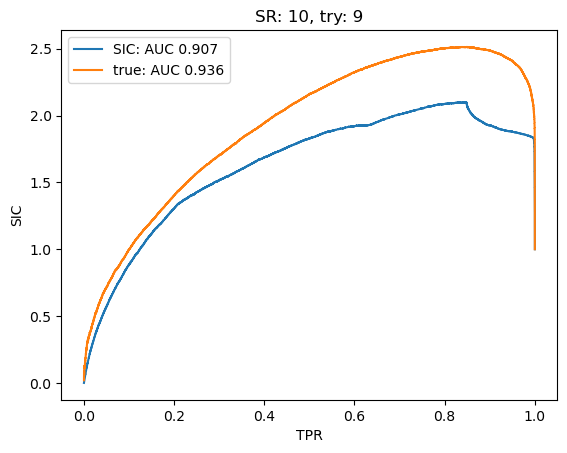

In [172]:

# For each sigma, generate all SIC curves,
# and get the average max SIC curve for each sigma
# get average AUC for each sigma
# get average SIC_01 for each sigma
# get average SIC_001 for each sigma
summary = {}
sig_train_list = [5, 0.1, 0.2, 0.5, 0.8, 0.9, 1, 2, 1.5, 10]
_true_max_SIC = []
_true_AUC = []
_true_SIC_01 = []
_true_SIC_001 = []

max_SIC_avg = []
AUC_avg = []
SIC_01_avg = []
SIC_001_avg = []

max_SIC_std = []
AUC_std = []
SIC_01_std = []
SIC_001_std = []


summary = {}


for sig_train in sig_train_list:
    _max_SIC = []
    _AUC = []
    _SIC_01 = []
    _SIC_001 = []


    x_test = data[str(sig_train)]['val']['data']
    label_test = data[str(sig_train)]['val']['label']

    test_tensor = torch.from_numpy(x_test.astype('float32').reshape((-1,1))).to(device)

    w1 = true_w[str(sig_train)][0]
    w2 = true_w[str(sig_train)][1]
    true_likelihood = p_data(x_test,[sig_mean, back_mean],[sig_simga**2,back_sigma**2],[w1,w2])/p_back(x_test,back_mean,back_sigma**2)
    sic_true , tpr_true , auc_true = SIC(label_test, true_likelihood)
    sic_true_01 = SIC_fpr(label_test, true_likelihood, 0.1)
    sic_true_001 = SIC_fpr(label_test, true_likelihood, 0.01)

    _true_max_SIC.append(np.max(sic_true))
    _true_AUC.append(auc_true)
    _true_SIC_01.append(sic_true_01)
    _true_SIC_001.append(sic_true_001)


    for try_ in range(10):
        model = define_model(nfeatures=1,nhidden=2,hidden_size=20,embedding=None,dropout=0,nembedding=0,device=device)
        SR_file = f'results/nflows_gaussian_mixture_1/SR_{sig_train}/try_{try_}'
        best_model_file = f'{SR_file}/model_SR_best.pt'
        model.load_state_dict(torch.load(best_model_file))
        model.eval()
        model.to(device)

        with torch.no_grad():
            SR = model.log_prob(test_tensor).cpu().detach().numpy()
       # SR_score_file = f'{SR_file}/best_val_loss_scores.npy'
      #  SR = np.load(SR_score_file)

        plt.hist(SR,bins=100,histtype='step')
        plt.hist(SR[label_test==0],bins=100, label='background',histtype='step')
        plt.hist(SR[label_test==1],bins=100, label='signal',histtype='step')
        plt.legend()
       # plt.savefig(f'{SR_file}/SR_hist.png')
        plt.close()

        SR = SR[mean_CR>0]
        label_test_ = label_test[mean_CR>0]

        CR_ = mean_CR[mean_CR>0]
        assert len(CR_) == len(SR)

        likelihood_score = SR - np.log(CR_)

        plt.hist(likelihood_score,bins=100,histtype='step')
        plt.hist(likelihood_score[label_test_==0],bins=100, label='background',histtype='step')
        plt.hist(likelihood_score[label_test_==1],bins=100, label='signal',histtype='step')
        plt.legend()
        plt.yscale('log')
       # plt.savefig(f'{SR_file}/likelihood_hist.png')
        plt.close()

     
        sic , tpr , auc = SIC(label_test_, likelihood_score)

        _max_SIC.append(np.max(sic))
        _AUC.append(auc)

        sic_01 = SIC_fpr(label_test_, likelihood_score, 0.1)
        sic_001 = SIC_fpr(label_test_, likelihood_score, 0.01)

        _SIC_01.append(sic_01)
        _SIC_001.append(sic_001)

        figure = plt.figure()

        plt.plot(tpr,sic,label='SIC: AUC {:.3f}'.format(auc))
        plt.plot(tpr_true,sic_true,label='true: AUC {:.3f}'.format(auc_true))
        plt.xlabel('TPR')
        plt.ylabel('SIC')
        plt.title(f'SR: {sig_train}, try: {try_}')
        plt.legend()
     #   plt.savefig(f'{SR_file}/SIC.png')
      #  plt.show()

    max_SIC_avg.append(np.mean(_max_SIC))
    max_SIC_std.append(np.std(_max_SIC))

    AUC_avg.append(np.mean(_AUC))
    AUC_std.append(np.std(_AUC))

    SIC_01_avg.append(np.mean(_SIC_01))
    SIC_01_std.append(np.std(_SIC_01))

    SIC_001_avg.append(np.mean(_SIC_001))
    SIC_001_std.append(np.std(_SIC_001))

plt.figure()
plt.errorbar(sig_train_list,max_SIC_avg,yerr=max_SIC_std,label='max SIC',fmt='o')
plt.plot(sig_train_list,_true_max_SIC,'o',label='true max SIC')
plt.xlabel('sig_train')
plt.ylabel('max SIC')
plt.legend()
plt.xscale('log')
plt.savefig('anode_max_SIC.png')
plt.close()

plt.figure()
plt.errorbar(sig_train_list,AUC_avg,yerr=AUC_std,label='AUC',fmt='o')
plt.plot(sig_train_list,_true_AUC,'o',label='true AUC')
plt.xlabel('sig_train')
plt.ylabel('AUC')
plt.legend()
plt.xscale('log')
plt.savefig('anode_AUC.png')
plt.close()

plt.figure()
plt.errorbar(sig_train_list,SIC_01_avg,yerr=SIC_01_std,label='SIC_01',fmt='o')
plt.plot(sig_train_list,_true_SIC_01,'o',label='true SIC_01')
plt.xlabel('sig_train')
plt.ylabel('SIC_01')
plt.legend()
plt.xscale('log')
plt.savefig('anode_SIC_01.png')
plt.close()

plt.figure()
plt.errorbar(sig_train_list,SIC_001_avg,yerr=SIC_001_std,label='SIC_001',fmt='o')
plt.plot(sig_train_list,_true_SIC_001,'o',label='true SIC_001')
plt.xlabel('sig_train')
plt.ylabel('SIC_001')
plt.legend()
plt.xscale('log')
plt.savefig('anode_SIC_001.png')
plt.close()


summary['sig_train'] = sig_train_list
summary['max_SIC_avg'] = max_SIC_avg
summary['max_SIC_std'] = max_SIC_std
summary['AUC_avg'] = AUC_avg
summary['AUC_std'] = AUC_std
summary['SIC_01_avg'] = SIC_01_avg
summary['SIC_01_std'] = SIC_01_std
summary['SIC_001_avg'] = SIC_001_avg
summary['SIC_001_std'] = SIC_001_std


    


